In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Set path
path = 'drive/MyDrive/SB_practical_notebooks/data/'
#path = 'drive/MyDrive/data/'

In [ ]:
!pip install scipy
!pip install matplotlib
!pip install biopython

In [ ]:
"""
Polipeptide chain - residue number - main chain atom - dihedral angle
        :
     - N    R     > 3 N            PSI   PHI  PSI
        \
         C - O    > 2 C       PHI  PSI   PHI
     \  /
      CA          > 2 CA      PHI  PSI
     /  \
    R    N -      > 2 N  PSI  PHI  PSI
        /
   O - C          > 1 C  PSI  PHI
        \  /
         CA       > 1 CA PSI
        /  \
       N    R     > 1 N  PSI
"""

from Bio.PDB import PDBList, calc_angle, calc_dihedral, PPBuilder, is_aa
from Bio.PDB.PDBParser import PDBParser

import math
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import numpy as np

In [ ]:
pdb_id = '1cu4'

# Fetch a PDB file to the current dir
pdbl = PDBList()
pdbl.retrieve_pdb_file(pdb_id, pdir=path, file_format='pdb')

# Load the structure
structure = PDBParser(QUIET=True).get_structure(pdb_id, path + "pdb{}.ent".format(pdb_id))


Structure exists: 'drive/MyDrive/SB_practical_notebooks/data/pdb1cu4.ent' 


In [ ]:
# Measure distance, angle, dihedral
atom1 = structure[0]['L'][52]['C']
atom2 = structure[0]['L'][53]['N']
atom3 = structure[0]['L'][53]['CA']
atom4 = structure[0]['L'][53]['C']

print("Distance {} - {} --> {} \u212B".format(atom1.full_id, atom4.full_id, atom1 - atom4))
print("Angle", math.degrees(calc_angle(atom1.get_vector(), atom2.get_vector(), atom3.get_vector())))
print("Angle radians", calc_angle(atom1.get_vector(), atom2.get_vector(), atom3.get_vector()))
print("Dihedral (PHI)", math.degrees(calc_dihedral(atom1.get_vector(), atom2.get_vector(), atom3.get_vector(), atom4.get_vector())))



Distance ('1cu4', 0, 'L', (' ', 52, ' '), ('C', ' ')) - ('1cu4', 0, 'L', (' ', 53, ' '), ('C', ' ')) --> 3.0374350547790527 Å
Angle 120.3151476548105
Angle radians 2.0998954665995773
Dihedral (PHI) -73.04776417166285


In [ ]:
# Build the peptides (reveal structure holes) and print sequences
print("Peptides")
ppb = PPBuilder()  # PolyPeptideBuilder
for model in structure:
    for chain in model:
        print(chain.id, len([residue for residue in chain if is_aa(residue)]))
        for pp in ppb.build_peptides(chain):
            print(len(pp), pp.get_sequence())


Peptides
L 219
219 DVVMTQTPLSLSVTIGQPASISCKSSQSLLDSDGKTYLIWVFQRPGQSPKRLIFLVSKRDSGVPDRFTGSGSGTDFTLKISRVEAEDVGVYYCWQGTHFPHTVGGGTKLEIARADAAPTVSIFPPSSEQLTSGGASVVCFLNNFYPKDINVKWKIDGSERQNGVLNSWTDQDSKDSTYSMSSTLTLTKDEYERHNSYTCEATHKTSTSPIVKSFNRNEC
H 215
215 KLQQSGAELVRSGASVKLSCTASGFNIKDYYIQWVKQRPEQGLEWIGWIDPENGNSEYAPRFQGKATMTADTLSNTAYLQLSSLTSEDTAVYYCNADLHDYWGQGTTLTVSSAKTTAPSVYPLAPVCGDTTGSSVTLGCLVKGYFPEPVTLTWNSGSLSSGVHTFPAVLQSDLYTLSSSVTVTSSTWPSQSITCNVAHPASSTKVDKKIEPRVTS
P 10
10 APKTNMKHMA


In [ ]:
# Calculate PSI and PHI
rama = {}  # { chain : [[residue_1, ...], [phi_residue_1, ...], [psi_residue_2, ...] ] }
for model in structure:
    for chain in model:
        for pp in ppb.build_peptides(chain):

            phi_psi = pp.get_phi_psi_list()  # [(phi_residue_1, psi_residue_1), ...]
            for i, residue in enumerate(pp):
               # print(model, chain, i, residue, phi_psi[i])

                # Convert radians to degrees and remove first and last value that are None
                if phi_psi[i][0] is not None and phi_psi[i][1] is not None:
                    rama.setdefault(chain.id, [[], [], []])
                    rama[chain.id][0].append(residue)
                    rama[chain.id][1].append(math.degrees(phi_psi[i][0]))
                    rama[chain.id][2].append(math.degrees(phi_psi[i][1]))


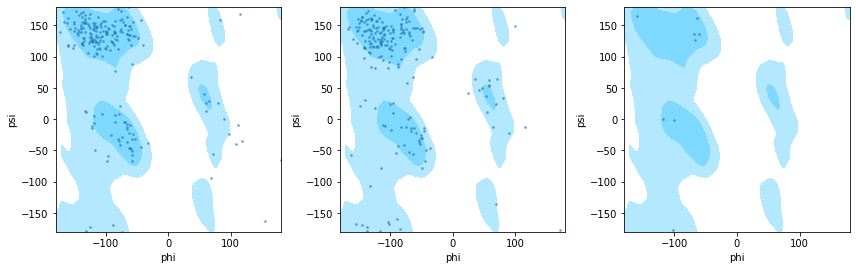

In [ ]:
# Ramachandran regions
# 2 = 90%, 1 = 60%
regions_matrix = []
with open(path + "ramachandran.dat") as f:
    for line in f:
        if line:
            regions_matrix.append([int(ele) for ele in line.strip().split()])

# Plot Ramachandran regions
cmap = mplcolors.ListedColormap(['#FFFFFF', '#B3E8FF', '#7FD9FF'])

f, axes = plt.subplots(1, len(rama), figsize=(12, 12))
axes = np.array(axes).reshape(-1)  # Hack to give consistency for single/multiple suplots (-1 force reshape to infer dimensions)
for ax, chain_id in zip(axes, rama):

    # Plot regions (60 percentile & 90 percentile)
    im = ax.imshow(regions_matrix, cmap=cmap, extent=(-180, 180, -180, 180))

    # Plot points
    ax.scatter(rama[chain_id][1], rama[chain_id][2], s=3, alpha=0.5)

    ax.set_xlabel('phi')
    ax.set_ylabel('psi')

plt.tight_layout()  # Remove figure padding
plt.savefig(path +'ramachandran_regions.png', bbox_inches='tight')

#Exercises

* Compare the Ramachandran plot with DynoPlot plugin https://raw.githubusercontent.com/Pymol-Scripts/Pymol-script-repo/master/plugins/dynoplot.py

* Calculate how many points are outside high confidence regions for the PDB 1az5 and how many are in the middle confidence range
